In [0]:
#header for accessing google drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131289 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.6-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

# Identifying fraudulent credit card transactions

The goal of this project is to build a classifier able to identify fraudulent credit card transactions. We will use the dataset from https://www.kaggle.com/mlg-ulb/creditcardfraud. Each instance of this dataset represents a credit card transaction, containing the features of the transaction and the label (being either fraudulent or normal). We will see that this dataset is quite imbalanced, containing very little instances of fraudulent transactions. Working with the raw imbalanced data would severely compromise the performance of the classification models, and therefore oversampling will be applied.

Three models will be applied to the dataset, namely decision trees, logistic regression and random forests. Moreover,  crossvalidation will be performed for an accurate estimate of the generalization error. Finally we will search for the best hyperparameters for the best performing model.

## Header

In [0]:
import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterSampler, ParameterGrid
from sklearn.metrics import accuracy_score,recall_score, precision_score, confusion_matrix

from imblearn.over_sampling import SMOTE

!pip install texttable
from texttable import Texttable


## **Loading and preparing data**

We will load the dataset and explore the number of instances of each class:



In [0]:
path = '/content/drive/fraud_credit_card/creditcard.csv'
file = pd.read_csv(path)

no_fraud = file.loc[file['Class']==0]
fraud = file.loc[file['Class']==1]
data = pd.concat((no_fraud,fraud),axis=0)

print('No fraud: ',no_fraud.shape)
print('Fraud: ',fraud.shape)


No fraud:  (284315, 31)
Fraud:  (492, 31)


It is clear that the fraudulent card transactions contitute only a small percentage of the dataset. Therefore, it is necessary to balance the data used for training, and this will be done by applying oversampling during crossvalidation.

The dataset will be divided into features and targets:

In [0]:
#separating features from targets
feat_cols = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

X = data[feat_cols].values
y = data['Class'].values

## **Model evaluation with crossvalidation**

In order to evaluate the generalization error of the models used the data needs to be splitted into training and testing data. Since an arbitrary train-test split might not yield an accurate estimate of the generalization error, several train-test splits will be used. 

Crossvalidation consists in dividing the dataset into k folds containing the same class ratio as the original data. The model is trained on k-1 folds and the remaining data is used for testing. This procedure is repeated until each fold is used for testing once. 

Of course the training data will still be imbalanced. Both undersampling and oversampling could be applied. In this case oversampling using [SMOTE ](https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html?highlight=SMOTE) was chosen due to the small amount of instaces of the minority class. SMOTE will be applied to the training data for each crossvalidation iteration. 

Although decision trees and random forests don't mind unnormalized data logistic regression does, so the data will be scaled between 0 and 1. In order to avoid any data leakage the scaler will be fit on the training data and applied to the test data. 

For each iteration of crossvalidation the classifier will be trained on the train data and evaluated on the test data, and the metrics are stored. After crossvalidation the average scores are returned.




In [0]:
def cross_validation(clf,n_splits=3):

  #cv splitter
  skf = StratifiedKFold(n_splits=n_splits,shuffle=True)
  
  acc_tr,acc_ts = [],[]
  recall_tr,recall_ts = [],[]
  precision_tr,precision_ts = [],[]
  cm_ts = []

  for train_index,test_index in skf.split(X, y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #oversampling
    X_train,y_train = SMOTE().fit_resample(X_train, y_train)
    
    #scaling
    min_max_scaler = preprocessing.MinMaxScaler()
    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)
    
    #fit
    clf.fit(X_train,y_train)
    
    #metrics train
    acc_tr.append(accuracy_score(y_train,clf.predict(X_train)))
    recall_tr.append(recall_score(y_train,clf.predict(X_train)))
    precision_tr.append(precision_score(y_train,clf.predict(X_train)))
    #metrics test
    acc_ts.append(accuracy_score(y_test,clf.predict(X_test)))
    recall_ts.append(recall_score(y_test,clf.predict(X_test)))
    precision_ts.append(precision_score(y_test,clf.predict(X_test)))
    cm_ts.append(confusion_matrix(y_test,clf.predict(X_test)))
    
  
  acc_tr = np.mean(acc_tr)
  recall_tr = np.mean(recall_tr)
  precision_tr = np.mean(precision_tr)
  acc_ts = np.mean(acc_ts)
  recall_ts = np.mean(recall_ts)
  precision_ts = np.mean(precision_ts)
  cm = sum(cm_ts)/n_splits
  
  metrics = {'acc_tr':acc_tr,'acc_ts':acc_ts,
             'recall_tr':recall_tr,'recall_ts':recall_ts,
             'precision_tr':precision_tr,'precision_ts':precision_ts,
             'cm':cm}
  
  return metrics


def plot_confusion_matrix(conf_matrix):
  df_cm = pd.DataFrame(conf_matrix, index = ['True Normal','True Fraud'],
                    columns = ['Pred Normal','Pred Fraud'])

  sn.heatmap(df_cm, annot=True)
  return


def print_metrics(metrics):
  t = Texttable()
  t.add_rows([[' ', 'Train','Test'], 
              ['Accuracy', metrics['acc_tr'], metrics['acc_ts']], 
              ['Precision', metrics['precision_tr'], metrics['precision_ts']],
              ['Recall', metrics['recall_tr'], metrics['recall_ts']]])
  print(t.draw())
  return
  


### Decision tree

The first model will be a decision tree classifier with default parameters, and we will apply crossvalidation to three folds:

In [0]:
metrics = cross_validation(DecisionTreeClassifier(),3)
print_metrics(metrics)

+-----------+-------+-------+
|           | Train | Test  |
+===========+=======+=======+
| Accuracy  | 1     | 0.998 |
+-----------+-------+-------+
| Precision | 1     | 0.429 |
+-----------+-------+-------+
| Recall    | 1     | 0.764 |
+-----------+-------+-------+


### Logistic regression

We will also apply logistic regression due to the simplicity and relatively good performance of this technique in some cases. The default number of maximum iterations fails to converged, so this parameter was increased:

In [0]:
metrics = cross_validation(LogisticRegression(solver='lbfgs',max_iter=500),3)
print_metrics(metrics)

+-----------+-------+-------+
|           | Train | Test  |
+===========+=======+=======+
| Accuracy  | 0.976 | 0.990 |
+-----------+-------+-------+
| Precision | 0.990 | 0.140 |
+-----------+-------+-------+
| Recall    | 0.961 | 0.886 |
+-----------+-------+-------+


### Random Forest

Finally we will apply a random forest classifier, which is expected to work better than a simple decision tree:

In [0]:
metrics  = cross_validation(RandomForestClassifier(n_estimators=10),3)
print_metrics(metrics)

+-----------+-------+-------+
|           | Train | Test  |
+===========+=======+=======+
| Accuracy  | 1.000 | 0.999 |
+-----------+-------+-------+
| Precision | 1.000 | 0.882 |
+-----------+-------+-------+
| Recall    | 1     | 0.815 |
+-----------+-------+-------+


The random forest model performs best, so this will be the model considered in the rest of this project.

We examine the confusion matrix to get an idea about the rate of false positives and negatives:

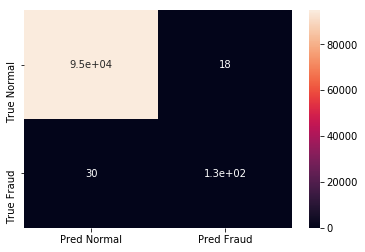

In [0]:
plot_confusion_matrix(metrics['cm'])

The imbalance of the data is clearly visible in the diagonal terms, being the number of fraudulent transactions orders of magnitude smaller than the number of normal transactions. Moreover, the number of false positives and negatives in the off-diagonal elements is way smaller than the correctly classified transactions, something expected due to the resulting values of precision and recall. 

## **Hyperparameter tuning of random forests**

Although the random forest model of the previous section performs well with default hyperparameters, it is expected that a different choice of hyperparameters might yield better performance.

It is of interest to see how varying each of the parameters of the classifier affects to the metrics considered. Since the dataset is very imbalanced the accuracy is not a good metric, so only recall and precision will be taken into account. 

The parameters considered are the number of estimators (decision trees), the depth of the trees, the minimum number of samples per node and the minimum number of samples for split. Each of these parameters will be explored individually by fixing the rest and varying the parameter of interest. 

For each of these experiments a parameter grid will be defined and the classifier will be trained for each of the configurations with 3-fold crossvalidation. This will give us an accurate estimate of the generalization error. Finally the validation curve for both accuracy and recall will be plotted:



In [0]:
def grid_search(grid,verbose=0):

  acc_tr,acc_ts = [],[]
  recall_tr,recall_ts = [],[]
  precision_tr,precision_ts = [],[]
  cm_ts = []

  for params in grid:

    clf = RandomForestClassifier(n_estimators = params['n_estimators'],
                                 max_depth = params['max_depth'],
                                 min_samples_split=params['min_samples_split'],
                                 min_samples_leaf=params['min_samples_leaf'])

    metrics = cross_validation(clf,3)
    
    acc_tr.append(metrics['acc_tr'])
    recall_tr.append(metrics['recall_tr'])
    precision_tr.append(metrics['precision_tr'])

    acc_ts.append(metrics['acc_ts'])
    recall_ts.append(metrics['recall_ts'])
    precision_ts.append(metrics['precision_ts'])
    cm_ts.append(metrics['cm'])
    
    if verbose == 1:
      print('Params: ',params)
      print('Accuracy: ',metrics['acc_ts'])
      print('Recall: ',metrics['recall_ts'])
      print('Precision: ',metrics['precision_ts'])
      print('\n')
  
    
  metrics = {'acc_tr':acc_tr,'acc_ts':acc_ts,
           'recall_tr':recall_tr,'recall_ts':recall_ts,
           'precision_tr':precision_tr,'precision_ts':precision_ts,
           'cm':cm_ts}

  return metrics




def val_curve(p_name,grid,metrics): 
  
  param = []
  for params in grid:
    param.append(params[p_name])
    
  #recall
  fig_rec,ax_rec = plt.subplots()
  ax_rec.plot(param,metrics['recall_tr'],label='Train',color='b')
  ax_rec.plot(param,metrics['recall_ts'],label='Test',color='r')
  ax_rec.set_xlabel(p_name)
  ax_rec.set_ylabel('Recall')
  ax_rec.legend()
  
  #precision
  fig_pre,ax_pre = plt.subplots()
  ax_pre.plot(param,metrics['precision_tr'],label='Train',color='b')
  ax_pre.plot(param,metrics['precision_ts'],label='Test',color='r')
  ax_pre.set_xlabel(p_name)
  ax_pre.set_ylabel('Precision')
  ax_pre.legend()

  return

### **Number of estimators**

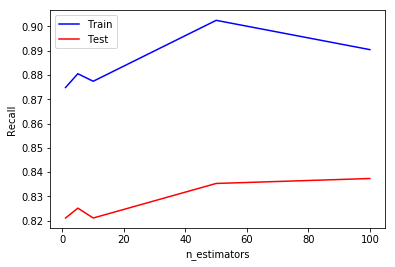

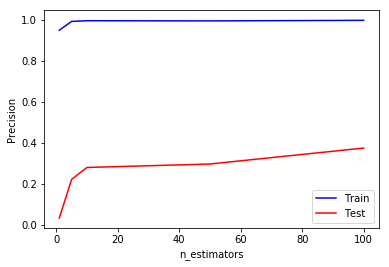

In [0]:
param_grid = ParameterGrid({'n_estimators':[1,5,10,50,100],
              'max_depth':[1],
              'min_samples_split' : [2],
              'min_samples_leaf':[1]})

metrics = grid_search(param_grid)
val_curve('n_estimators',param_grid,metrics) 

We observe that both precision and accuracy increase with the number of estimators as expected. From now on the number of estimators considered will be 100.

### **Max depth**

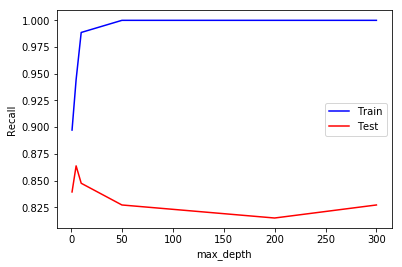

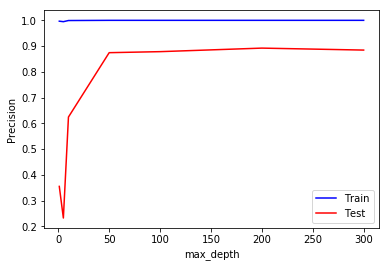

In [0]:
param_grid = ParameterGrid({'n_estimators':[100],
              'max_depth':[1,5,10,50,100,200,300],
              'min_samples_split' : [2],
              'min_samples_leaf':[1]})

metrics = grid_search(param_grid)
val_curve('max_depth',param_grid,metrics) 

From the validation curves above it is clear that a maximum depth of 50 is reasonable, and this will be the value for the rest of the project.

### **Min samples split**

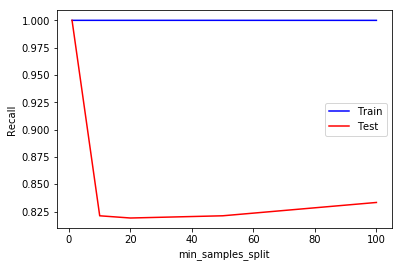

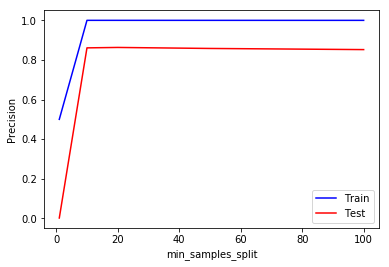

In [0]:
param_grid = ParameterGrid({'n_estimators':[100],
              'max_depth':[50],
              'min_samples_split' : [1.0,10,20,50,100],
              'min_samples_leaf':[1]})

metrics = grid_search(param_grid)
val_curve('min_samples_split',param_grid,metrics) 

### **Min samples leaf**

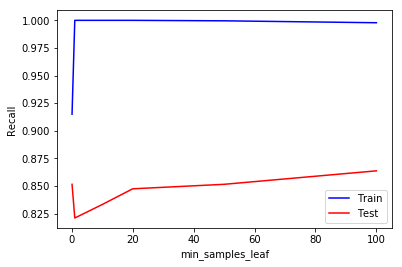

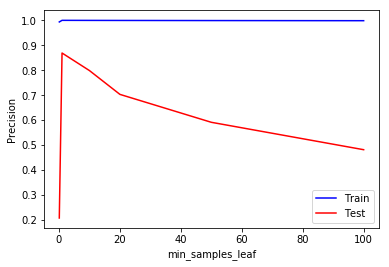

In [0]:
param_grid = ParameterGrid({'n_estimators':[100],
              'max_depth':[50],
              'min_samples_split' : [25],
              'min_samples_leaf':[0.1,1,10,20,50,100]})

metrics = grid_search(param_grid)
val_curve('min_samples_leaf',param_grid,metrics) 

### **Random Search**


The previous validation curves have been obtained by varying only one parameter and keeping the rest fixed. Therefore, it might be that we missed a combination of parameters that yields better results.

To perform a more exhaustive hyperparameter search we will construct a parameter grid containing all possible combinations of hyperparameters. Next, we will sample uniformly from the parameter grid and we evaluate the resulting model. 

This is computationally less expensive than grid search and it provides with similar results (see reference [here](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf))



In [0]:
param_grid = {'n_estimators':[50,100,150],
              'max_depth':[50,100,150],
              'min_samples_split' : [10,20,50],
              'min_samples_leaf':[0.1,1,10,20]}

param_grid = ParameterSampler(param_grid,n_iter = 15)
metrics = grid_search(param_grid,verbose=1)

Params:  {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 50}
Accuracy:  0.999494394153685
Recall:  0.8252032520325203
Precision:  0.8767228939642733


Params:  {'n_estimators': 150, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 150}
Accuracy:  0.9993539483647037
Recall:  0.8394308943089431
Precision:  0.7996865199648336


Params:  {'n_estimators': 150, 'min_samples_split': 50, 'min_samples_leaf': 0.1, 'max_depth': 150}
Accuracy:  0.9948702052489683
Recall:  0.8455284552845529
Precision:  0.23651783715384242


Params:  {'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_depth': 150}
Accuracy:  0.9991678573836325
Recall:  0.8536585365853658
Precision:  0.718114400705366


Params:  {'n_estimators': 150, 'min_samples_split': 50, 'min_samples_leaf': 10, 'max_depth': 50}
Accuracy:  0.9993258594510062
Recall:  0.8394308943089431
Precision:  0.7872563967458529


Params:  {'n_estimators': 150, 'min_samples_split': 10, 'mi